In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook', font_scale=1.3)

import itertools as it
from collections import Counter, defaultdict, deque

In [2]:
# ---------- Functional utils ---------- #
from toolz import pipe
from toolz.curried import *
max = curry(max)
min = curry(min)
call = lambda f: f()
@curry
def attr(name, obj):
    return getattr(obj, name)
@curry
def invoke(name, obj):
    return getattr(obj, name)()

lmap = curry(compose(list, map))
amap = curry(compose(np.array, lmap))

In [3]:
import json

In [4]:
UP = 0
RIGHT = 1
DOWN = 2
LEFT = 3


In [29]:
from envs import GridWorld
from agents import *

with open('maze_19_1.json') as f:
    maze = json.load(f)
spec = np.stack(maze['map'])
goal = tuple(maze['goal'])
spec[goal] = GridWorld.GOAL

def heuristic(env, obs):
    row, col = obs
    g_row, g_col = env.goal
    return env.move_cost * (abs(row - g_row) + abs(col - g_col))

(5, 5)
86 1.0


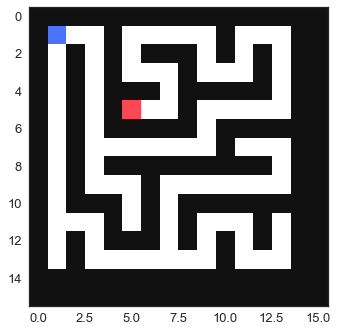

In [126]:
from agents import *
from envs import GridWorld
agent = Agent()
env = GridWorld.random_maze(16)
env.reset()
print(env.goal)
env.render()
policy = MetaSearchPolicy()
agent.register(env)
agent.register(policy)
trace = agent.run_episode()
print(len(trace['actions']), trace['return'])

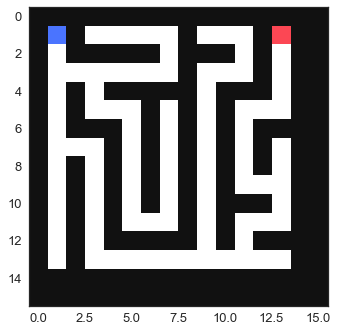

In [89]:
from IPython.display import HTML
from matplotlib import animation, rc
rc('animation', html='html5')

def display_animation(anim):
    plt.close(anim._fig)
    return HTML(anim_to_html(anim))


fig = plt.figure()


from matplotlib import colors
from matplotlib import pyplot as plt
cdef = ['#ffffff', '#111111', '#FC4754', '#4A74FF']
cmap = colors.ListedColormap(cdef)
bounds = np.arange(cmap.N + 1)
cnorm = colors.BoundaryNorm(bounds, cmap.N)

env.reset()
X = env.render(mode='array')

frontier = True
if frontier:
    im = plt.imshow(X, aspect='equal', cmap=cmap, norm=cnorm, animated=True)
    frames = policy.saved['frontier']
    def updatefig(h):
    #     r,c = h['state']
        X1 = X.copy()
        for (r,c) in h:
            X1[r,c] = 3
        im.set_array(X1)
        return im,
else:
    im = plt.imshow(X, aspect='equal', cmap=cmap, norm=cnorm, animated=True)
    frames = iter(trace['actions'])
    def updatefig(a):
        env.step(a)
        X = env.render(mode='array')
        im.set_array(X)
        return im,

anim = animation.FuncAnimation(fig, updatefig, interval=200, blit=True, 
                        frames=frames, )
anim
# anim.save('a-star.gif', writer='imagemagick', fps=10)

In [ ]:
env.reset()
env.render(mode='human')
for a in tr['actions']:
    time.sleep(1)
    env.step(a)
    env.render(mode='human')


In [ ]:
N_EP = 40
SIZE = 10
from agents import *
from envs import ForageWorld
env = ForageWorld(SIZE, 4, .05)
agent = Agent()
agent.register(env)
env.reset()
V = BayesianRegressionV()
agent.register(V)
agent.register(SearchPolicy(V, noise=0))
trace = agent.run_many(N_EP, max_steps=100)

In [ ]:
np.random.randn()

In [ ]:
from scipy.stats import norm

In [ ]:
def ret(n, sig):
    return sum(np.random.randn() * sig for _ in range(n))

d = [ret(2, 1) for _ in range(1000)]
sns.distplot(d)
norm.fit(d)
    

In [ ]:
softmax([1,1,2])

In [ ]:
x = np.random.rand(4)
theta = np.random.rand(4, 2)
x @ theta

In [ ]:
plt.plot(rolling_max(map(get('v'), agent.policy.node_history), 200))

In [ ]:
df = pd.DataFrame(trace)
df['return'].plot()

In [ ]:
sns.set_style('whitegrid')
w = V.model.w
idx = [0,1,2,3,4,5,6,7,8,9,10,len(w)-1]
w = w[idx]
var = V.model.sigma_w[idx]
# plt.bar(range(len(idx)), w)
plt.errorbar(range(len(idx)), w, var)
# plt.fill_between(range(len(idx)), w-var, w+var, alpha=0.4)
# plt.ylim(-2, 2)

In [ ]:
from utils import dict_product
from envs import ForageWorld
from agents import *

def rolling_max(seq, length):
    seq = iter(seq)
    best = next(seq)
    lst = np.zeros(length) - 1000
    lst[0] = best
    for i, x in enumerate(seq, start=1):
        best = max(x, best)
        lst[i] = best 
    for j in range(i, length):
        lst[j] = best
    return lst
    
        

def data(params, n=20):
    for i, pr in enumerate(params):
        print(pr)
        env = ForageWorld(**pr)
        agent = Agent()
        agent.register(env)
        V = FixedV([0, 1] + [0] * (pr['size'] ** 2))
        agent.register(V)
        agent.register(SearchPolicy(V, noise=0))
        rets = []
        for _ in range(n):
            agent.run_episode()
            nh = agent.policy.node_history
            rets.append(rolling_max(map(get('v'), nh), 2000))
        yield {**pr, 'ret': np.stack(rets).mean(0)}

params = {
    'size': [6,8,10,12],
    'n_berry': 5,
    'time_cost': 0.05,
}
df = pd.DataFrame(data(dict_product(params)))

In [ ]:
time_cost = np.arange(2000) * -0.001
colors = iter(sns.color_palette('deep'))
color = defaultdict(lambda: next(colors))
ls = {0.05: '-', 0.1: '--'}
for (nb, s, tc), dd in df.groupby(['n_berry', 'size', 'time_cost']):
    x = dd.ret.iloc[0] + time_cost
    plt.plot(x[:1000], c=color[s], ls=ls[tc])
plt.legend()

In [ ]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, Image
sns.set_style('whitegrid')

def display_animation(anim):
    plt.close(anim._fig)
    return HTML(anim.to_html5_video())

def get_states(path):
    env.reset()
    yield (SIZE // 2, SIZE //2)
    for a in path:
        s1, r, done, _ = env.step(a)
        yield env._state[:2]

def init():
    pathcol.set_offsets([[], []])
    return [pathcol]

def update(i, pathcol, nodes):
    data = np.array(list(get_states(nodes[i].path)))
    pathcol.set_offsets(data)
    return [pathcol]

fig = plt.figure()
ax = plt.axes(xlim=(-0.5, SIZE+.5), ylim=(-0.5, SIZE+.5))
plt.xticks(range(0,SIZE))
plt.yticks(range(0,SIZE))
ax.scatter(*np.array(list(env.berry_locs.keys())).T, 
           c='r', marker='x',  s=120)
pathcol = ax.scatter([], [], s=100)

nodes = agent.policy.node_history[200:300]
T = len(nodes)

anim = FuncAnimation(
    fig, update, init_func=init, fargs=(pathcol, nodes), interval=200, frames=T, 
    blit=True, repeat=True)

display_animation(anim)

In [ ]:
plot = plt.scatter([], [], s=100)
fig1 = plt.figure()
plt.axis('equal')
plt.xlim(0, SIZE)
plt.ylim(0, SIZE)

nodes = agent.policy.node_history
ani = FuncAnimation(fig1, plot_node, 20, fargs=(nodes, plot),      
                                   interval=100, blit=True)
display_animation(ani)

In [ ]:
df = pd.DataFrame(trace)
sns.factorplot('berries', 'return', data=df)
plt.axis('equal')
# plt.plot([0, 2], [0, 2], ls='--')

In [ ]:
# N_EP = 50
# trace = agent.run_many(N_EP, max_steps=100)
roll = 2

df = pd.DataFrame(trace)
cols = ['v0', 'vx', 'vy', 'vb'] 
# cols.extend(['vxy', 'vxb', 'vyb'])
tdf = pd.DataFrame(list(df.theta_v), columns=cols).clip(-10, 100)
df = df.join(tdf).drop('theta_v', axis=1)
# sns.factorplot('berries', 'return', data=df)
# df['return'].rolling(roll).mean().plot()
# sns.lmplot('i_episode', 'vb', data=df)
df[cols + ['return', 'berries']].rolling(roll).mean().plot()
plt.axhline(0, ls='--', c='gray')

In [ ]:
from sklearn.linear_model import SGDRegressor
n_samples, n_features = 100, 5
X = np.random.randn(n_samples, n_features)
theta = np.random.randn(n_features)
y = X @ theta + 0.5 * np.random.randn(n_samples)
clf = SGDRegressor()
clf.fit(X, y)
theta_hat = np.linalg.inv(X.T @ X) @ (X.T @ y)
def rms_error(y1, y2):
    return ((y1 - y2) ** 2).mean() ** 0.5

print('{:.3f}  {:.3f}'.format(
    rms_error(y, clf.predict(X)),
    rms_error(y, X @ theta_hat)),
)


In [ ]:
class LinearSGD(object):
    """Learns a linear approximation by SGD."""
    def __init__(self, shape, learn_rate=.1):
        self.shape = shape
        self.learn_rate = learn_rate
        self.theta = np.random.random(self.shape)

    def update(self, x, y):
        yhat = x @ self.theta
        error = y - yhat
        self.theta += self.learn_rate * np.outer(x, error)

    def predict(self, x):
        return x @ self.theta

mod = LinearSGD((n_features, 1), .1)
for i in range(len(X)):
    mod.update(X[i], y[i])

yhat = [mod.predict(x)[0] for x in X]
rms_error(y, yhat)

In [ ]:
from sklearn.linear_model import SGDRegressor
n_samples, n_features, n_output = 10, 5, 2
X = np.random.randn(n_samples, n_features)
theta = np.random.randn(n_features, n_output)
y = X @ theta
# clf = SGDRegressor()
# clf.partial_fit(X, y)
y

In [ ]:
clf.fit(X, y)
theta_hat = np.linalg.inv(X.T @ X) @ (X.T @ y)
def rms_error(y1, y2):
    return ((y1 - y2) ** 2).mean() ** 0.5

print('{:.3f}  {:.3f}'.format(
    rms_error(y, clf.predict(X)),
    rms_error(y, X @ theta_hat)),
)

In [ ]:
def bin(x):
    return pd.cut(x, 10).apply(lambda x: x.mid)

bdf = pd.DataFrame({
    'vb': bin(df.vb),
    'ep': bin(df.i_episode),
    'return': df['return']
})
sns.heatmap(bdf.pivot_table('return', 'vb', 'ep'))

In [ ]:
agent.depth = 2
agent.run_episode()

In [ ]:
V = agent.V.to_array().reshape(5, 5)
sns.heatmap(V)

In [ ]:
from agents import QLearningAgent
from envs import GridEnv

env = GridEnv(5, 5)
agent = QLearningAgent(env)
agent.Q.theta
# agent.Q.theta
# trace = agent.run_many(500)
agent.run_many(100)

In [ ]:
plt.plot(trace['return'])

In [ ]:
# agent.run_many(1000)
print(agent.V.theta)
# agent.V.theta = np.array([0, 100])
X = np.linspace(-1,1, 101)
plt.plot(X, lmap(agent.V, map(agent.phi, X)))